Driver script to import and pre-process the OASIS brain data.
Builds and trains the VQVAE model, generating images and SSIM accuracy of the test dataset.

@author Mallika Mukherji
@email m.mukherji@uqconnect.edu.au

In [ ]:
# Load VQVAE model file to colab 
from google.colab import files
src = list(files.upload().values())[0]
open('VQVAE.py','wb').write(src)

# Load PixelCNN model file to colab
src = list(files.upload().values())[0]
open('pixelcnn.py','wb').write(src)

Saving VQVAE.py to VQVAE.py


Saving pixelcnn.py to pixelcnn (2).py


3392

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from VQVAE import *
from pixelcnn import *

In [ ]:
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.6.0


# Load OASIS brain data

In [ ]:
# Load keras data set to colab 
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/My\ Drive/keras_png_slices_data.zip

In [ ]:
# Initialise paths for training, testing and validation sets
TRAIN_IMAGE_PATH = "keras_png_slices_data/keras_png_slices_train"
TEST_IMAGE_PATH = "keras_png_slices_data/keras_png_slices_test"
VAL_IMAGE_PATH = "keras_png_slices_data/keras_png_slices_validate"

In [ ]:
# Incitialise directories for training, testing and validation data
train_files = os.listdir(TRAIN_IMAGE_PATH)
test_files = os.listdir(TEST_IMAGE_PATH)
validate_files = os.listdir(VAL_IMAGE_PATH)

In [ ]:
# Initialise image dimensions for model
IMG_HEIGHT = 80
IMG_WIDTH = 80

In [ ]:
def load_images(path, image_files):
    """
    Returns a list of resized images at the given path.
    """
    images = []

    for file in image_files:
        image = Image.open(path + '/' + file) 
        image = image.resize((IMG_HEIGHT, IMG_WIDTH))
        image = np.reshape(image, (IMG_HEIGHT, IMG_WIDTH, 1))
        images.append(image)
        
    return images

In [ ]:
# Load images into lists
train_images = load_images(TRAIN_IMAGE_PATH, train_files)
test_images = load_images(TEST_IMAGE_PATH, test_files)

# Pre-process the data

In [ ]:
# Convert lists into np arrays
x_train = np.array(train_images)
x_test = np.array(test_images)

In [ ]:
# Normalise the OASIS brain data to be [-0.5, 0.5].
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

# Calculate data variance to normalise Mean Squared Error
data_variance = np.var(x_train / 255.0)

# Check shapes of arrays
print(x_train.shape)
print(data_variance.shape)

(9664, 80, 80, 1)
()


# Visualise the data

In [ ]:
def display(display_list):
    """
    Displays the given list of images.
    """
    plt.figure(figsize=(6, 6))

    title = ['Train Image', 'Test Image']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap=plt.cm.gray)
        plt.axis('off')
    
    plt.show()

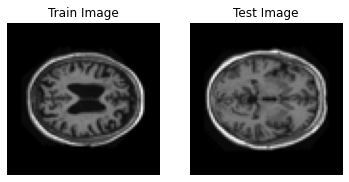

In [ ]:
# Check dataset has been successfully loaded and pre-processed.
display([x_train_scaled[0], x_test_scaled[0]])

# Train the VQ-VAE model

In [ ]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_history = vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
76/76 [==============================] - 8s 96ms/step - loss: 2.6785 - reconstruction_loss: 1.4431 - vqvae_loss: 0.2650
Epoch 2/30
76/76 [==============================] - 7s 96ms/step - loss: 7.7215 - reconstruction_loss: 0.3707 - vqvae_loss: 7.3130
Epoch 3/30
76/76 [==============================] - 7s 96ms/step - loss: 1.3315 - reconstruction_loss: 0.2924 - vqvae_loss: 1.0329
Epoch 4/30
76/76 [==============================] - 7s 96ms/step - loss: 0.8700 - reconstruction_loss: 0.2761 - vqvae_loss: 0.5891
Epoch 5/30
76/76 [==============================] - 7s 95ms/step - loss: 0.6520 - reconstruction_loss: 0.2676 - vqvae_loss: 0.3821
Epoch 6/30
76/76 [==============================] - 7s 95ms/step - loss: 0.5412 - reconstruction_loss: 0.2592 - vqvae_loss: 0.2800
Epoch 7/30
76/76 [==============================] - 7s 95ms/step - loss: 0.4854 - reconstruction_loss: 0.2503 - vqvae_loss: 0.2334
Epoch 8/30
76/76 [==============================] - 7s 96ms/step - loss: 0.4687 - r

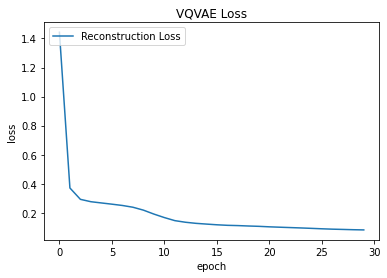

In [ ]:
# Plot loss for VQVAE model

plt.plot(vqvae_history.history['reconstruction_loss'])
plt.title('VQVAE Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Reconstruction Loss'], loc='upper left')
plt.show()

# Visualise reconstructions and calculate SSIM



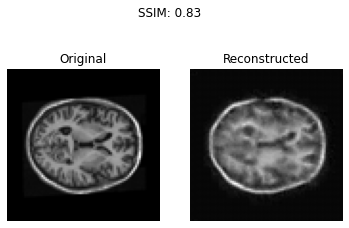

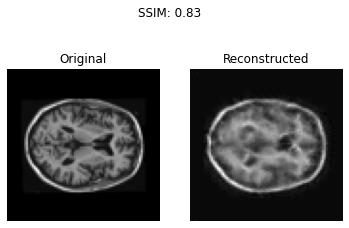

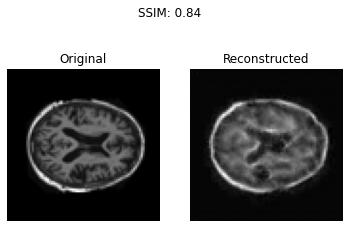

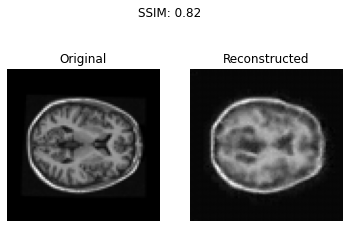

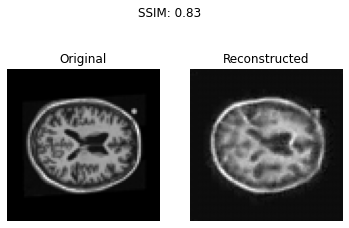

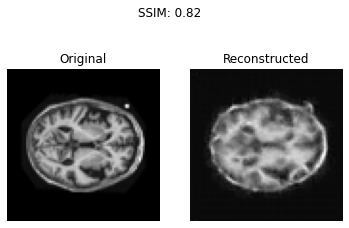

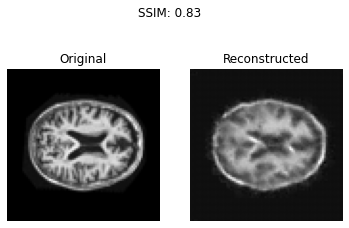

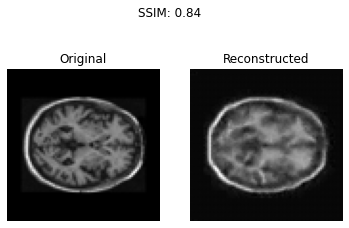

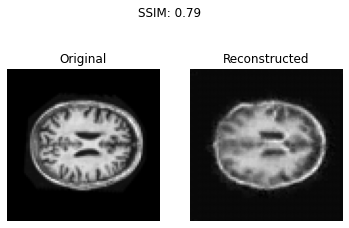

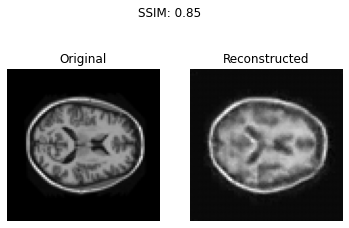

In [ ]:
def show_subplot(original, reconstructed):
    """
    Displays original and reconstructed image and their SSIM.
    Calculates and returns the SSIM between the two images
    """
    
    # Calculate SSIM
    image1 = tf.image.convert_image_dtype(original, tf.float32)
    image2 = tf.image.convert_image_dtype(reconstructed, tf.float32)
    ssim = tf.image.ssim(image1, image2, max_val=1.0)
    plt.suptitle("SSIM: %.2f" %ssim)
   
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5, cmap=plt.cm.gray)
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5, cmap=plt.cm.gray)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()
    return ssim 

trained_vqvae_model = vqvae_trainer.vqvae

# Choose 10 random test images
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]

# Perform predictions on test images
reconstructions_test = trained_vqvae_model.predict(test_images)

# The sum of the SSIM of all resconstructed images
total_ssim = 0.0

# Visualise reconstructions
for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    ssim = show_subplot(test_image, reconstructed_image)
    total_ssim = total_ssim + ssim

In [ ]:
# Calculate the mean SSIM for the reconstructed images
mean_ssim = total_ssim / len(reconstructions_test)
print(mean_ssim)

tf.Tensor(0.8285453, shape=(), dtype=float32)


# Visualise the discrete codes

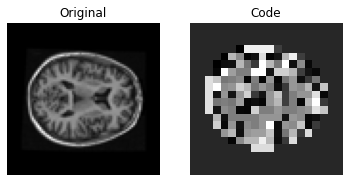

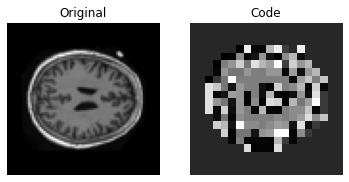

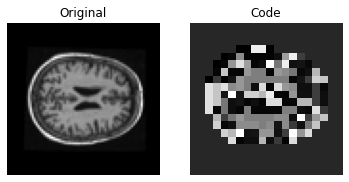

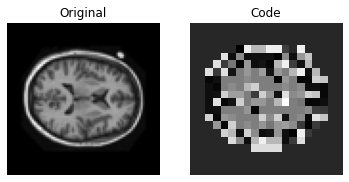

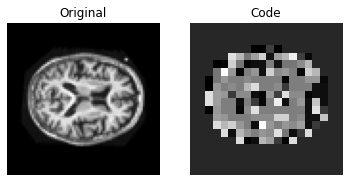

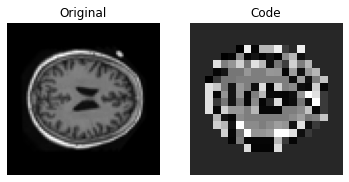

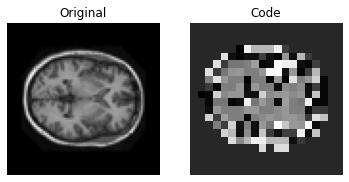

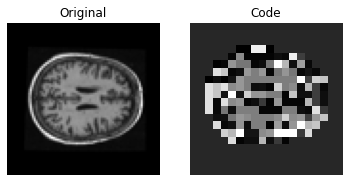

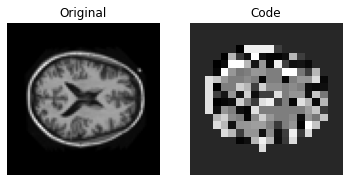

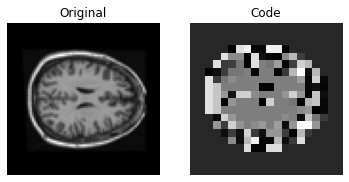

In [ ]:
# Initialise encoder and quantiser
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

# Flatten outputs from encoder
encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])

# Generate the codebook indices
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

# Visualise the orignal images and their discrete codes
for i in range(len(test_images)):
    
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5, cmap=plt.cm.gray)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i], cmap=plt.cm.gray)
    plt.title("Code")
    plt.axis("off")
    plt.show()

# Generate the codebook indices

In [ ]:
# Get the PixelCNN model

pixel_cnn = get_pixelcnn(vqvae_trainer, encoded_outputs)
pixel_cnn.summary()

Input shape of the PixelCNN: (20, 20)
Model: "pixel_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 20, 20)]          0         
_________________________________________________________________
tf.one_hot_1 (TFOpLambda)    (None, 20, 20, 128)       0         
_________________________________________________________________
pixel_conv_layer_5 (PixelCon (None, 20, 20, 128)       802944    
_________________________________________________________________
residual_block_2 (ResidualBl (None, 20, 20, 128)       98624     
_________________________________________________________________
residual_block_3 (ResidualBl (None, 20, 20, 128)       98624     
_________________________________________________________________
pixel_conv_layer_8 (PixelCon (None, 20, 20, 128)       16512     
_________________________________________________________________
pixel_conv_layer_9 

In [ ]:
# Flatten the encoder outputs.
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])

# Generate the codebook indices
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

Shape of the training data for PixelCNN: (9664, 20, 20)


# Train the PixelCNN model

In [ ]:
# Compile the PixelCNN Model
pixel_cnn.compile(optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],)

# Train the PixelCNN Model
pixelcnn_history = pixel_cnn.fit(x=codebook_indices, y=codebook_indices, 
                  batch_size=128, epochs=50, validation_split=0.1,)

Epoch 1/50
68/68 [==============================] - 9s 115ms/step - loss: 1.1427 - accuracy: 0.6542 - val_loss: 1.0927 - val_accuracy: 0.6654
Epoch 2/50
68/68 [==============================] - 7s 110ms/step - loss: 1.0664 - accuracy: 0.6718 - val_loss: 1.0345 - val_accuracy: 0.6794
Epoch 3/50
68/68 [==============================] - 7s 110ms/step - loss: 1.0007 - accuracy: 0.6881 - val_loss: 0.9669 - val_accuracy: 0.6965
Epoch 4/50
68/68 [==============================] - 7s 110ms/step - loss: 0.9338 - accuracy: 0.7047 - val_loss: 0.9043 - val_accuracy: 0.7116
Epoch 5/50
68/68 [==============================] - 7s 110ms/step - loss: 0.8783 - accuracy: 0.7174 - val_loss: 0.8578 - val_accuracy: 0.7224
Epoch 6/50
68/68 [==============================] - 7s 110ms/step - loss: 0.8382 - accuracy: 0.7271 - val_loss: 0.8243 - val_accuracy: 0.7310
Epoch 7/50
68/68 [==============================] - 7s 110ms/step - loss: 0.8085 - accuracy: 0.7348 - val_loss: 0.7987 - val_accuracy: 0.7372
Epoch 

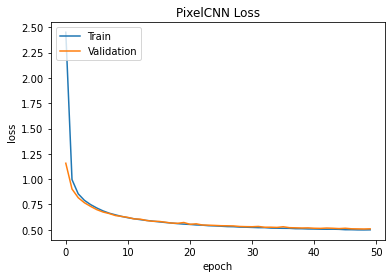

In [ ]:
# Plot loss for PixelCNN model

plt.plot(pixelcnn_history.history['loss'])
plt.plot(pixelcnn_history.history['val_loss'])
plt.title('PixelCNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

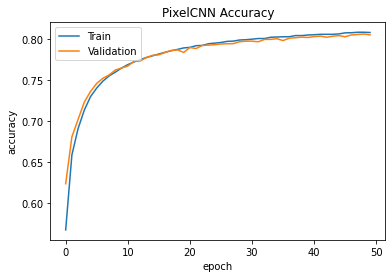

In [ ]:
# Plot accuracy for PixelCNN model

plt.plot(pixelcnn_history.history['accuracy'])
plt.plot(pixelcnn_history.history['val_accuracy'])
plt.title('PixelCNN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Generate priors

In [ ]:
def generate_priors(pixel_cnn):
  """
  Generates and returns the priors using the given PixelCNN model.
  """
  
  # Create an empty array of priors.
  batch = 10
  priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
  batch, rows, cols = priors.shape

  # Iterate over the priors because generation has to be done sequentially pixel by pixel.
  for row in range(rows):
      for col in range(cols):
          logits = pixel_cnn.predict(priors)
          sampler = tfp.distributions.Categorical(logits)
          probs = sampler.sample()
          priors[:, row, col] = probs[:, row, col]

  return priors

In [ ]:
# Generate the priors 
priors = generate_priors(pixel_cnn)
print(f"Prior shape: {priors.shape}")

Prior shape: (10, 20, 20)


# Generate and visualise novel images

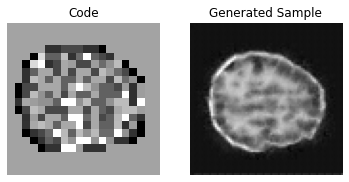

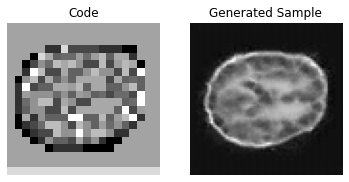

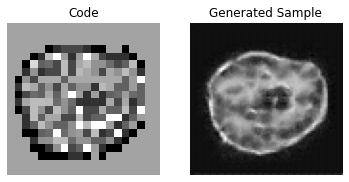

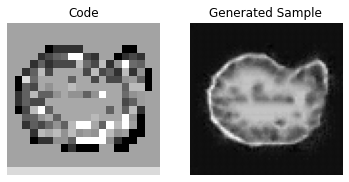

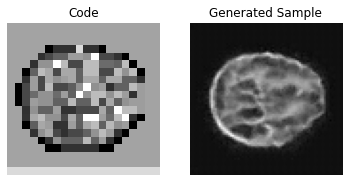

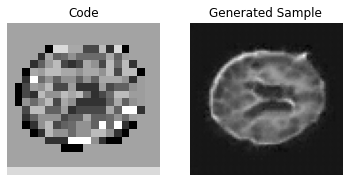

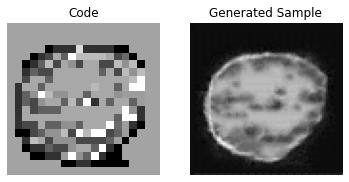

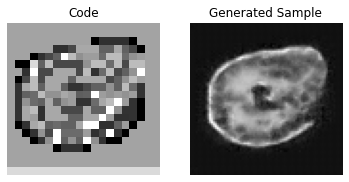

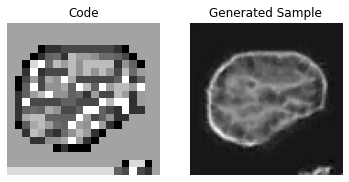

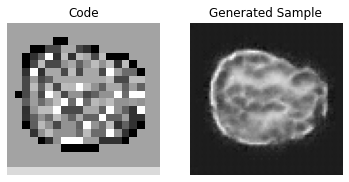

In [ ]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

# Visulaise the novel images generated from discrete codes
for i in range(10):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i], cmap = plt.cm.gray)
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5, cmap = plt.cm.gray)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()